In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import re
import scIB
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [2]:
raw_data_dir = "/storage/groups/ml01/projects/2019_scIB_daniel.strobl_michaela.mueller/TM/"
data_dir = "/storage/groups/ml01/workspace/group.daniela/tm/"

In [3]:
relevant_tissues = {'Bladder', 'Brain', 'Kidney', 'Liver', 'Lung', 'Mammary_Gland',
 'Marrow', 'Limb_Muscle', 'Pancreas', 'Spleen', 'Thymus'}
len(relevant_tissues)

11

## Read Data

In [4]:
facs_dirs = glob.glob(raw_data_dir+"smartseq2/FACS/*")
filtered_dirs = [i for i in facs_dirs if any(substr in i for substr in relevant_tissues)]

In [5]:
adatas = {}
for file_name in filtered_dirs:
    tmp = sc.read(file_name, cache=True, make_unique=False)
    tmp = tmp.transpose()
    
    ids = file_name.split("/")[-1].split("-")
    tissue = ids[0]
    print(tissue)
    tmp.obs['tissue'] = [tissue]*tmp.n_obs
    adatas[tissue] = tmp

Pancreas
Limb_Muscle
Bladder
Kidney
Liver
Thymus
Marrow
Spleen
Mammary_Gland
Brain_Myeloid
Brain_Non
Lung


In [6]:
adatas

{'Pancreas': AnnData object with n_obs × n_vars = 1961 × 23433 
     obs: 'tissue',
 'Limb_Muscle': AnnData object with n_obs × n_vars = 1151 × 23433 
     obs: 'tissue',
 'Bladder': AnnData object with n_obs × n_vars = 1638 × 23433 
     obs: 'tissue',
 'Kidney': AnnData object with n_obs × n_vars = 865 × 23433 
     obs: 'tissue',
 'Liver': AnnData object with n_obs × n_vars = 981 × 23433 
     obs: 'tissue',
 'Thymus': AnnData object with n_obs × n_vars = 1580 × 23433 
     obs: 'tissue',
 'Marrow': AnnData object with n_obs × n_vars = 5355 × 23433 
     obs: 'tissue',
 'Spleen': AnnData object with n_obs × n_vars = 1718 × 23433 
     obs: 'tissue',
 'Mammary_Gland': AnnData object with n_obs × n_vars = 2663 × 23433 
     obs: 'tissue',
 'Brain_Myeloid': AnnData object with n_obs × n_vars = 4762 × 23433 
     obs: 'tissue',
 'Brain_Non': AnnData object with n_obs × n_vars = 5799 × 23433 
     obs: 'tissue',
 'Lung': AnnData object with n_obs × n_vars = 1923 × 23433 
     obs: 'tissu

### Merge brain data

In [7]:
brain = adatas["Brain_Myeloid"].concatenate(adatas["Brain_Non"], index_unique=None)
brain.obs["tissue"] = "Brain"
adatas["Brain"] = brain

## Annotation

In [8]:
anno = pd.read_csv(raw_data_dir+"smartseq2/annotations_FACS.csv")

/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
anno.head()

,Neurog3>0_raw,Neurog3>0_scaled,cell,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,plate.barcode,...,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
0,NaN,NaN,A1.B000610.3_56_F.1.1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-7.182841,-10.895094
1,NaN,NaN,A1.B002764.3_38_F.1.1,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,4.199059,-11.050240
2,NaN,NaN,A1.B002771.3_39_F.1.1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-11.995435,-7.325534
3,NaN,NaN,A1.D041914.3_8_M.1.1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-6.820022,-14.174246
4,NaN,NaN,A1.D042253.3_9_M.1.1,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-24.163538,-7.499349


In [10]:
# rename brain tissues
anno[anno["tissue"].str.startswith("Brain")]["tissue"] = "Brain"

/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# add annotation for each tissue
for tissue in relevant_tissues:
    adata = adatas[tissue]
    print(tissue)
    adata.obs['cell'] = adata.obs_names
    obs_merged = pd.merge(adata.obs,
                          anno[['cell', 'mouse.id', 'mouse.sex', 'cell_ontology_class']], 
                          how='left', on='cell')
    obs_merged.rename(columns={'mouse.sex':'sex', 
                               'mouse.id':'sample',
                               'cell_ontology_class':'cell_type'},
                      inplace=True)
    obs_merged.drop(columns=['cell'], inplace=True)
    obs_merged.set_index(adata.obs.index, inplace=True)
    
    adata.obs = obs_merged

Mammary_Gland
Brain
Liver
Marrow
Limb_Muscle
Bladder
Thymus
Spleen
Pancreas
Lung
Kidney


## QC

In [12]:
plt.rcParams['figure.figsize'] = 8,8

In [13]:
adatas["Limb_Muscle"].obs["cell_type"].notnull()

index
L4.D042103.3_11_M.1        True
D1.D042103.3_11_M.1        True
N2.D042103.3_11_M.1        True
H4.D042103.3_11_M.1        True
E1.D042103.3_11_M.1        True
                          ...  
P20.D042473.3_10_M.1.1     True
I18.D042473.3_10_M.1.1     True
M19.D042473.3_10_M.1.1     True
O19.D042473.3_10_M.1.1    False
P21.D042473.3_10_M.1.1     True
Name: cell_type, Length: 1151, dtype: bool

Mammary_Gland
258 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

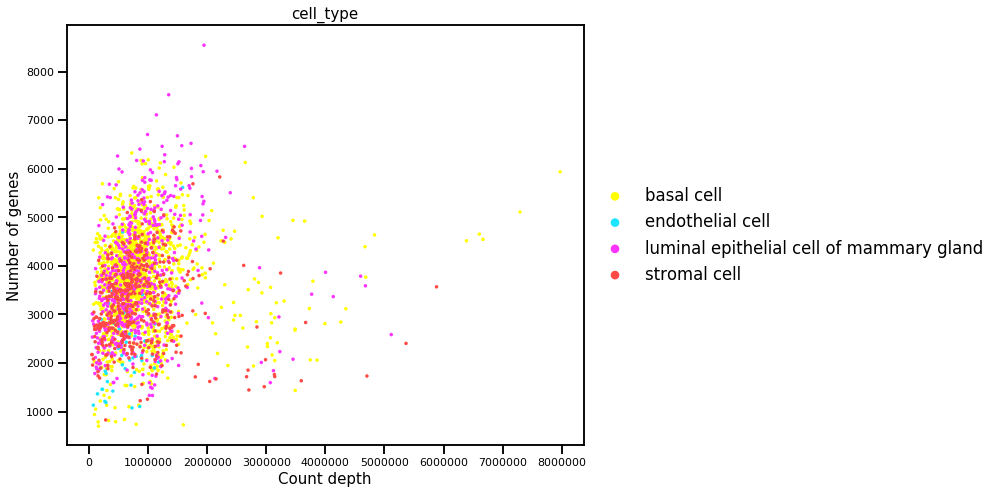

Brain
2705 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

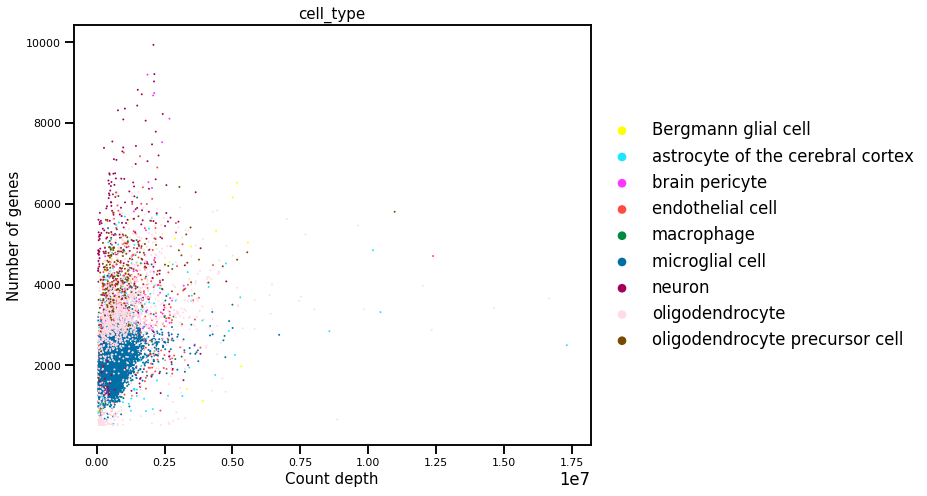

Liver
267 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

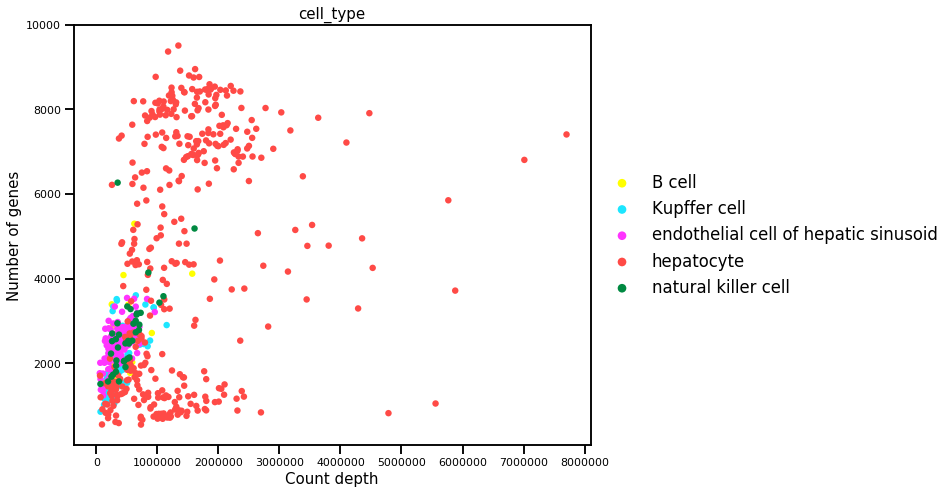

Marrow
318 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

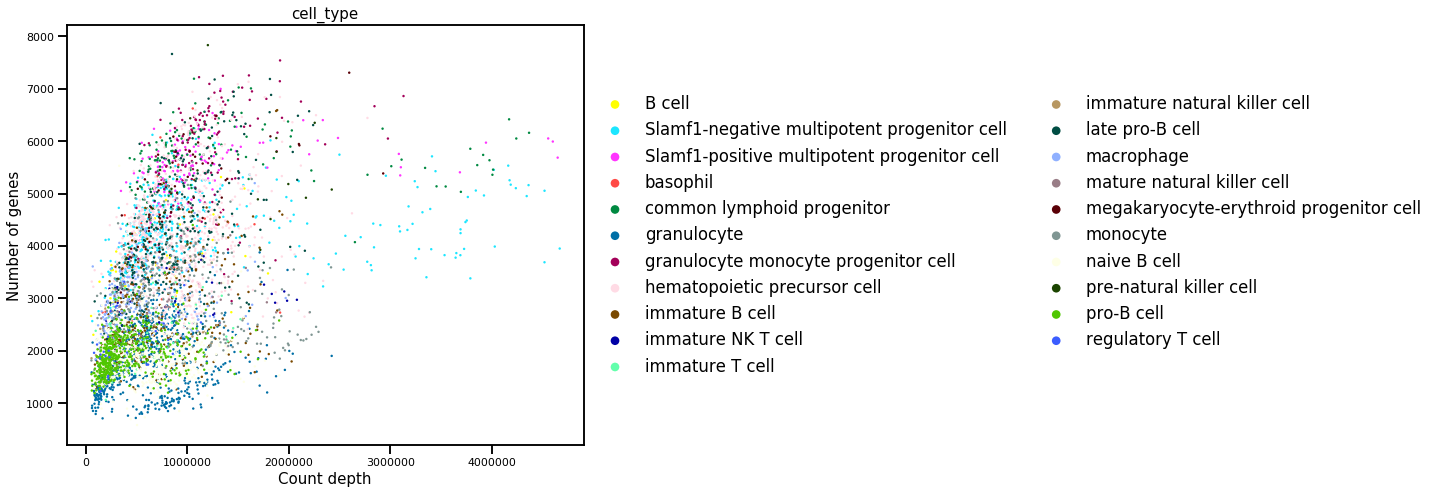

Limb_Muscle
61 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

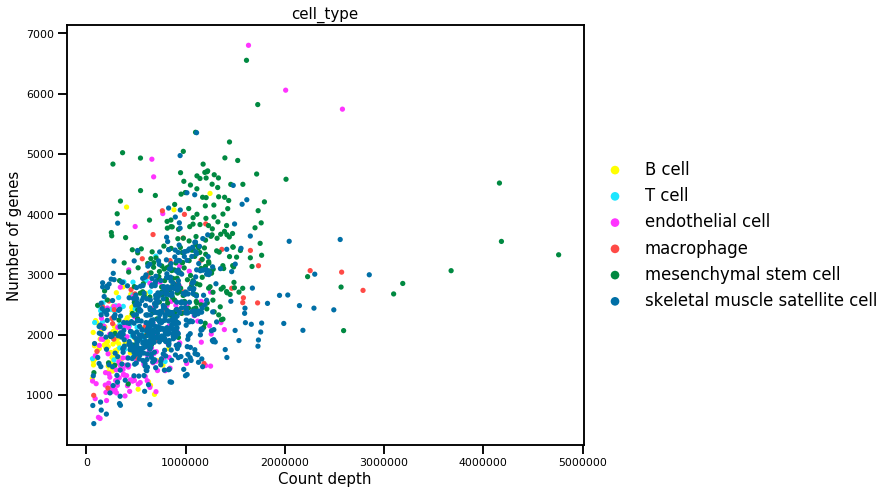

Bladder
260 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

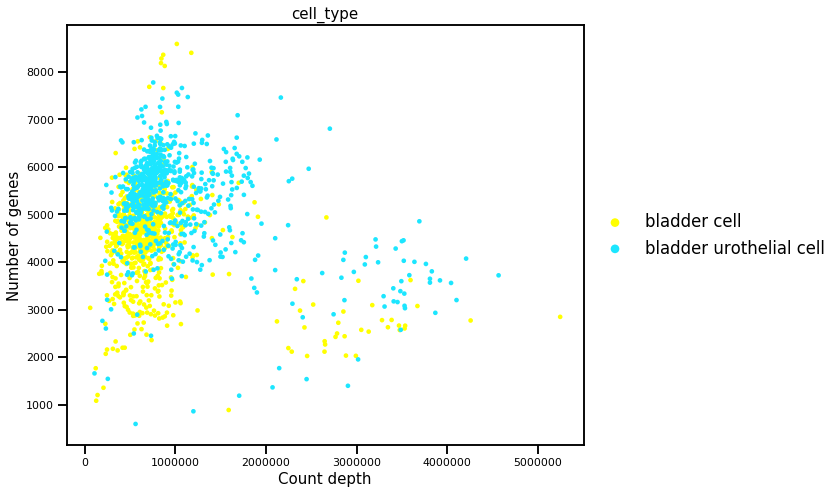

Thymus
231 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

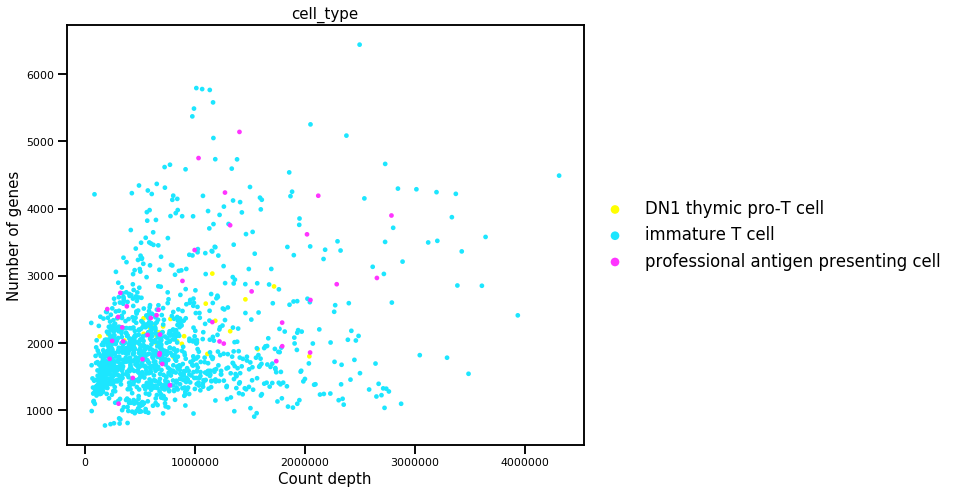

Spleen
21 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

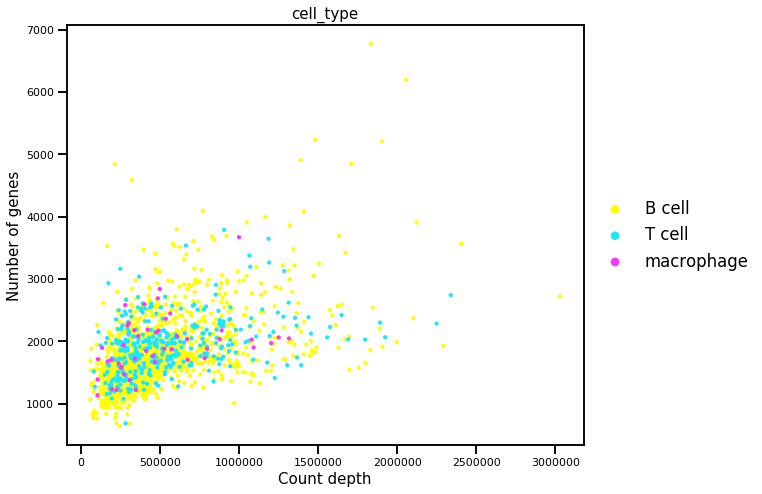

Pancreas
397 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

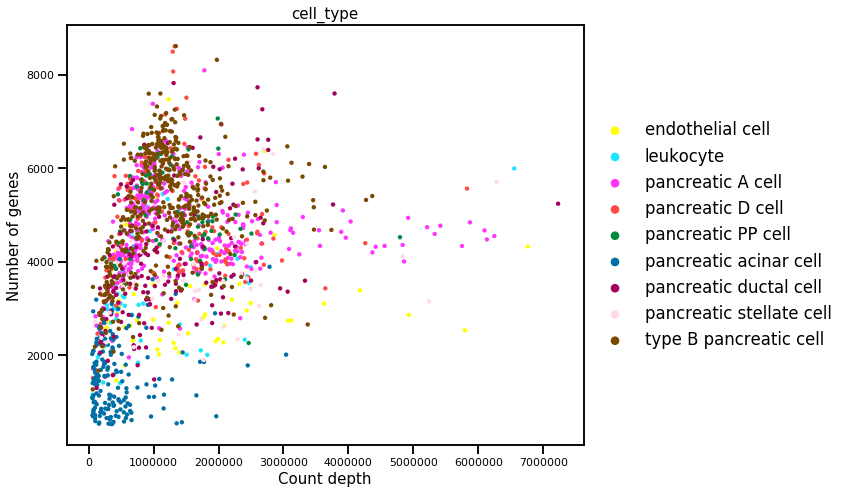

Lung
247 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

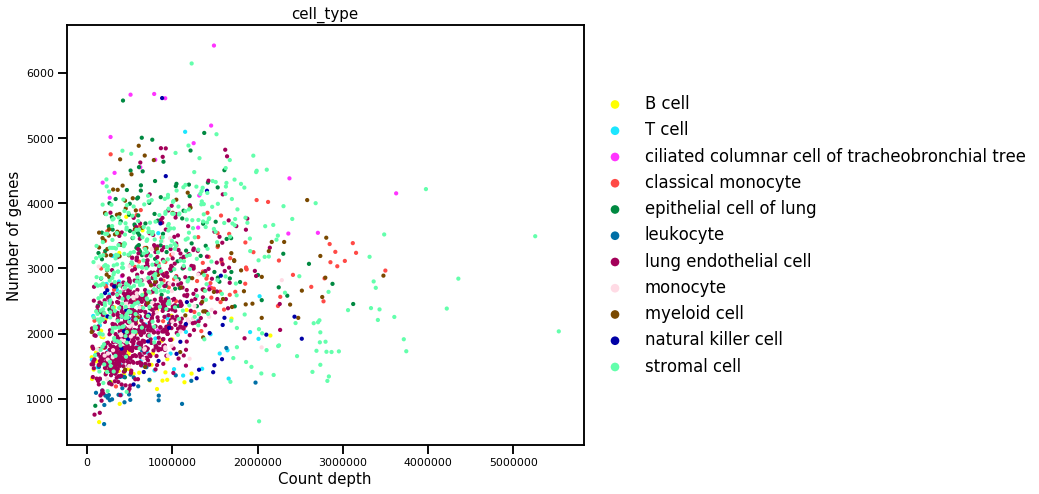

Kidney
346 cells with cell type 'nan' removed


Trying to set attribute `.obs` of view, making a copy.
... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sex' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/sca

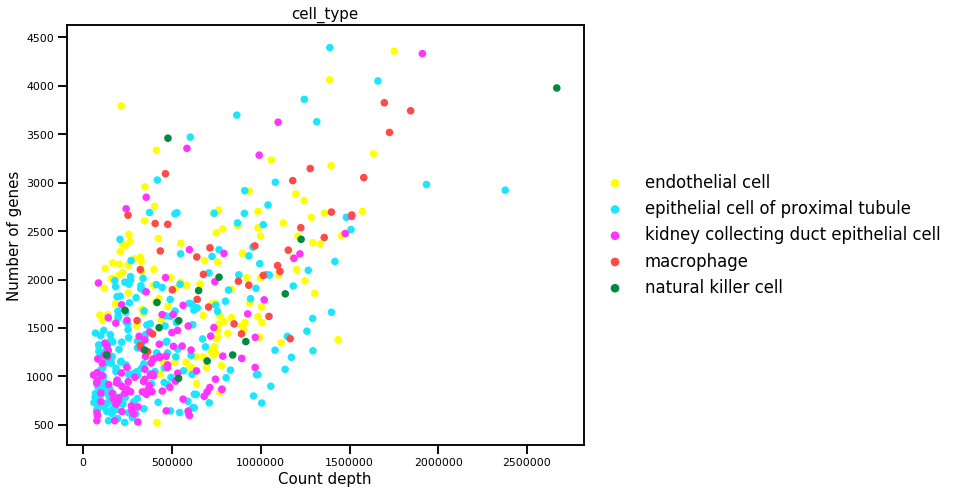

In [14]:
for tissue in relevant_tissues:
    adata = adatas[tissue]
    print(tissue)
    
    # remove cells that are annotated as "nan"
    size_before = adata.n_obs
    adata = adata[adata.obs["cell_type"].notnull()].copy()
    del adatas[tissue]
    adatas[tissue] = adata
    if size_before != adata.n_obs:
        print(f"{size_before - adata.n_obs} cells with cell type 'nan' removed")
    
    scIB.preprocessing.summarize_counts(adata)
    scIB.preprocessing.plot_QC(adata[adata.obs["tissue"] == tissue], color="cell_type")
    #sc.pl.violin(adata[adata.obs["tissue"] == tissue], keys=['n_genes', 'n_counts'],
    #         jitter=0.4, multi_panel=True)

## Save Tissues

In [15]:
adatas.keys()

dict_keys(['Brain_Myeloid', 'Brain_Non', 'Mammary_Gland', 'Brain', 'Liver', 'Marrow', 'Limb_Muscle', 'Bladder', 'Thymus', 'Spleen', 'Pancreas', 'Lung', 'Kidney'])

In [16]:
for tissue in relevant_tissues:
    adata = adatas[tissue]
    print(tissue)
    adata.write(f"{data_dir}facs/raw/{tissue}.h5ad")

... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Mammary_Gland


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Brain


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Liver


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Marrow


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Limb_Muscle


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Bladder


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Thymus


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Spleen


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Pancreas


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Lung


... storing 'tissue' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'cell_type' as categorical


Kidney
